In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import datasets,models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
import time
import copy
import numpy as np 
import pandas as pd 

In [2]:
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])
dataset_train=datasets.ImageFolder("./data/chimuf/train",transform=transform
                )
dataset_length=len(dataset_train)
trainset,valset=random_split(dataset_train,[int(0.8*dataset_length),dataset_length-int(0.8*dataset_length)])

In [3]:
loadeddata=DataLoader(dataset_train,batch_size=32,shuffle=True,num_workers=2)
loaded_train=DataLoader(trainset,batch_size=32,shuffle=True,num_workers=2)
loaded_val=DataLoader(valset,batch_size=32,shuffle=True,num_workers=2)

In [4]:
loadeddata

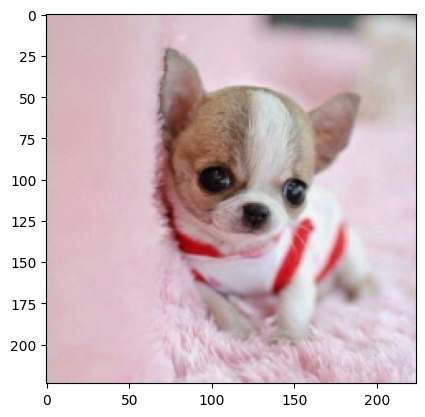

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
#     plt.pause(0.001) 
inp,classes=next(iter(loadeddata))
class_names=["muffin","chihuahua"]
out=torchvision.utils.make_grid(inp[0])

imshow(out)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
my_model=models.resnet50(pretrained=True)

C:\Users\DESKTOP\anaconda3\envs\cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DESKTOP\anaconda3\envs\cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
print(my_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
my_model.fc=nn.Linear(2048,2)

In [10]:
my_model=my_model.to(device)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in [loaded_train,loaded_val][phase=='val']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                inputs.unsqueeze(0)
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / [int(0.8*dataset_length),dataset_length-int(0.8*dataset_length)][phase=='val']
            epoch_acc = running_corrects.double() / [int(0.8*dataset_length),dataset_length-int(0.8*dataset_length)][phase=='val']

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(my_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1026 Acc: 0.9662
val Loss: 0.0195 Acc: 0.9958

Epoch 1/24
----------
train Loss: 0.0166 Acc: 0.9963
val Loss: 0.0142 Acc: 0.9958

Epoch 2/24
----------
train Loss: 0.0119 Acc: 0.9974
val Loss: 0.0110 Acc: 0.9958

Epoch 3/24
----------
train Loss: 0.0082 Acc: 0.9982
val Loss: 0.0092 Acc: 0.9958

Epoch 4/24
----------
train Loss: 0.0062 Acc: 0.9989
val Loss: 0.0085 Acc: 0.9979

Epoch 5/24
----------
train Loss: 0.0031 Acc: 0.9997
val Loss: 0.0072 Acc: 0.9989

Epoch 6/24
----------
train Loss: 0.0039 Acc: 0.9995
val Loss: 0.0066 Acc: 0.9968

Epoch 7/24
----------
train Loss: 0.0027 Acc: 0.9997
val Loss: 0.0068 Acc: 0.9968

Epoch 8/24
----------
train Loss: 0.0044 Acc: 0.9987
val Loss: 0.0114 Acc: 0.9958

Epoch 9/24
----------
train Loss: 0.0032 Acc: 0.9995
val Loss: 0.0073 Acc: 0.9968

Epoch 10/24
----------
train Loss: 0.0021 Acc: 1.0000
val Loss: 0.0078 Acc: 0.9968

Epoch 11/24
----------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.0074 Acc: 0.9979

Ep